# Delays and offsets

To validate our results we look at different delays and offsets. The goal here is to analyse the effect of different prior delays and different game offsets.

In [1]:
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os
import pandas as pd
import datetime
import matplotlib.ticker as ticker
import pymc3 as pm
import arviz as az
sys.path.append("../../")
sys.path.append("../../covid19_inference")
sys.path.append("../")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
#import covid19_inference as cov19
from header_plotting import *

def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)

In [11]:
%load_ext autoreload
%autoreload 2

def load_function(country, offset=0, mwd="1.0", interval_cps="10.0", f_fem="0.33", f_robust="1.0", len="normal"):
        folder="covid_uefa_traces14_robustness"
        fstr=lambda tune, draws, max_treedepth, folder: (f"/data.nst/share/soccer_project/{folder}/run"+
            f"-beta=False"+
            f"-country={country}"+
            f"-offset_data={offset}"+
            f"-prior_delay=-1"+
            f"-median_width_delay={mwd}"+
            f"-interval_cps={interval_cps}"+
            f"-f_fem={f_fem}"+
            f"-len=normal"+
            f"-abs_sine=False"+
            f"-t={tune}"+
            f"-d={draws}"+
            f"-max_treedepth={max_treedepth}.pkl")
        if not f_robust == "1.0":
            fstr=lambda tune, draws, max_treedepth, folder: (f"/data.nst/share/soccer_project/covid_uefa_traces14/run"+
                f"-beta=False"+
                f"-country={country}"+
                f"-offset_data={offset}"+
                f"-prior_delay=-1"+
                f"-median_width_delay={mwd}"+
                f"-interval_cps={interval_cps}"+
                f"-f_fem={f_fem}"+
                f"-len=normal"+
                f"-abs_sine=False"+
                f"-t={tune}"+
                f"-d={draws}"+
                f"-max_treedepth={max_treedepth}.pkl")
        model = None
        
        tune, draws, max_treedepth = (2000, 4000, 12)
        folder="covid_uefa_traces14_robustness"
        if os.path.exists(fstr(tune, draws, max_treedepth, folder)):
            model, trace = load(fstr(tune, draws, max_treedepth, folder))
            print(f"Use {draws} sample runs for {country} with {offset} offset")
            
        tune, draws, max_treedepth = (1000, 2000, 12)
        folder="covid_uefa_traces15"
        if os.path.exists(fstr(tune, draws, max_treedepth, folder)):
            model, trace = load(fstr(tune, draws, max_treedepth, folder))
            print(f"Use {draws} sample runs for {country} with {offset} offset")
        tune, draws, max_treedepth = (500, 1000, 12)
        if os.path.exists(fstr(tune, draws, max_treedepth, folder)):
            model, trace = load(fstr(tune, draws, max_treedepth, folder))
            print(f"Use {draws} sample runs for {country} with {offset} offset")
        
        if model is None: 
            print(fstr(tune, draws, max_treedepth, folder), " not found")
            return None, None
        
        # Remove chains with likelihood larger than -200, should only be the case for 2 chains in France
        mask = (np.mean(trace.sample_stats.lp, axis=1)>-200)
        trace.posterior = trace.posterior.sel(chain=~mask)
        return model, trace

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Offset
#offsets = [-35,-28,-8,-6,-4,-2,-1, 0, 1, 2, 4, 6, 8, 28, 35]
countries = ['England', 'Czechia', 'Scotland', 'Spain', 'Italy', 'Slovakia',
       'Germany', 'Austria', 'Belgium', 'France', 'Portugal',
       'Netherlands']
offsets = [-2, -1, 0, 1, 2]

models = {}
traces, traces_without_soccer, traces_primary_soccer  = {} , {} , {}
dls = {}
for country in tqdm(countries):
    models_temp = []
    traces_temp = []
    traces_without_soccer_temp = []
    traces_primary_soccer_temp = []
    dls_temp = []
    for offset in offsets:
        print(f"{country} {offset}" )

        model,trace = load_function(country, offset= offset)
    
        dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country],offset_data=offset)
        models_temp.append(model)
        traces_temp.append(trace)
        
        
        dls_temp.append(dl)
    models[country] = models_temp
    
    traces[country] = traces_temp
    traces_without_soccer[country] = traces_without_soccer_temp
    traces_primary_soccer[country] = traces_primary_soccer_temp
    
    dls[country] = dls_temp

  0%|          | 0/12 [00:00<?, ?it/s]

England -2
Use 4000 sample runs for England with -2 offset
England -1
Use 4000 sample runs for England with -1 offset
England 0
Use 4000 sample runs for England with 0 offset
England 1
Use 4000 sample runs for England with 1 offset
England 2
Use 4000 sample runs for England with 2 offset
Czechia -2
Use 4000 sample runs for Czechia with -2 offset
Czechia -1
Use 4000 sample runs for Czechia with -1 offset
Czechia 0
Use 4000 sample runs for Czechia with 0 offset
Czechia 1
Use 4000 sample runs for Czechia with 1 offset
Czechia 2
Use 4000 sample runs for Czechia with 2 offset
Scotland -2
Use 4000 sample runs for Scotland with -2 offset
Scotland -1
Use 4000 sample runs for Scotland with -1 offset
Scotland 0
Use 4000 sample runs for Scotland with 0 offset
Scotland 1
Use 4000 sample runs for Scotland with 1 offset
Scotland 2
Use 4000 sample runs for Scotland with 2 offset
Spain -2
Use 4000 sample runs for Spain with -2 offset
Spain -1
Use 4000 sample runs for Spain with -1 offset
Spain 0
Use 4

In [33]:

    
# Compute interesting values as fractionv
primary_frac = []
for i, country in enumerate(countries):
    primary_frac_t = []
    
    for o, offset in enumerate(offsets):
        if models[country][o] is None:
            print(f"Country {country} with offset {offset} not found")
            o = 2
        
            
        frac_pr = covid19_soccer.plot.other.calc_fraction_primary(model=models[country][o], trace=traces[country][o], dl=dls[country][o])
        primary_frac_t.append(frac_pr*100)
    primary_frac.append(primary_frac_t)

Country Slovakia with offset 2 not found
Country France with offset 1 not found


# Create plot different offests

/home/jdehning/repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:1257: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_male, lw=0,),)
/home/jdehning/repositories/covid19_soccer/notebooks/supplementary/../../covid19_soccer/plot/other.py:1261: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lines.append(Patch([0], [0], color=rcParams.color_female, lw=0,),)


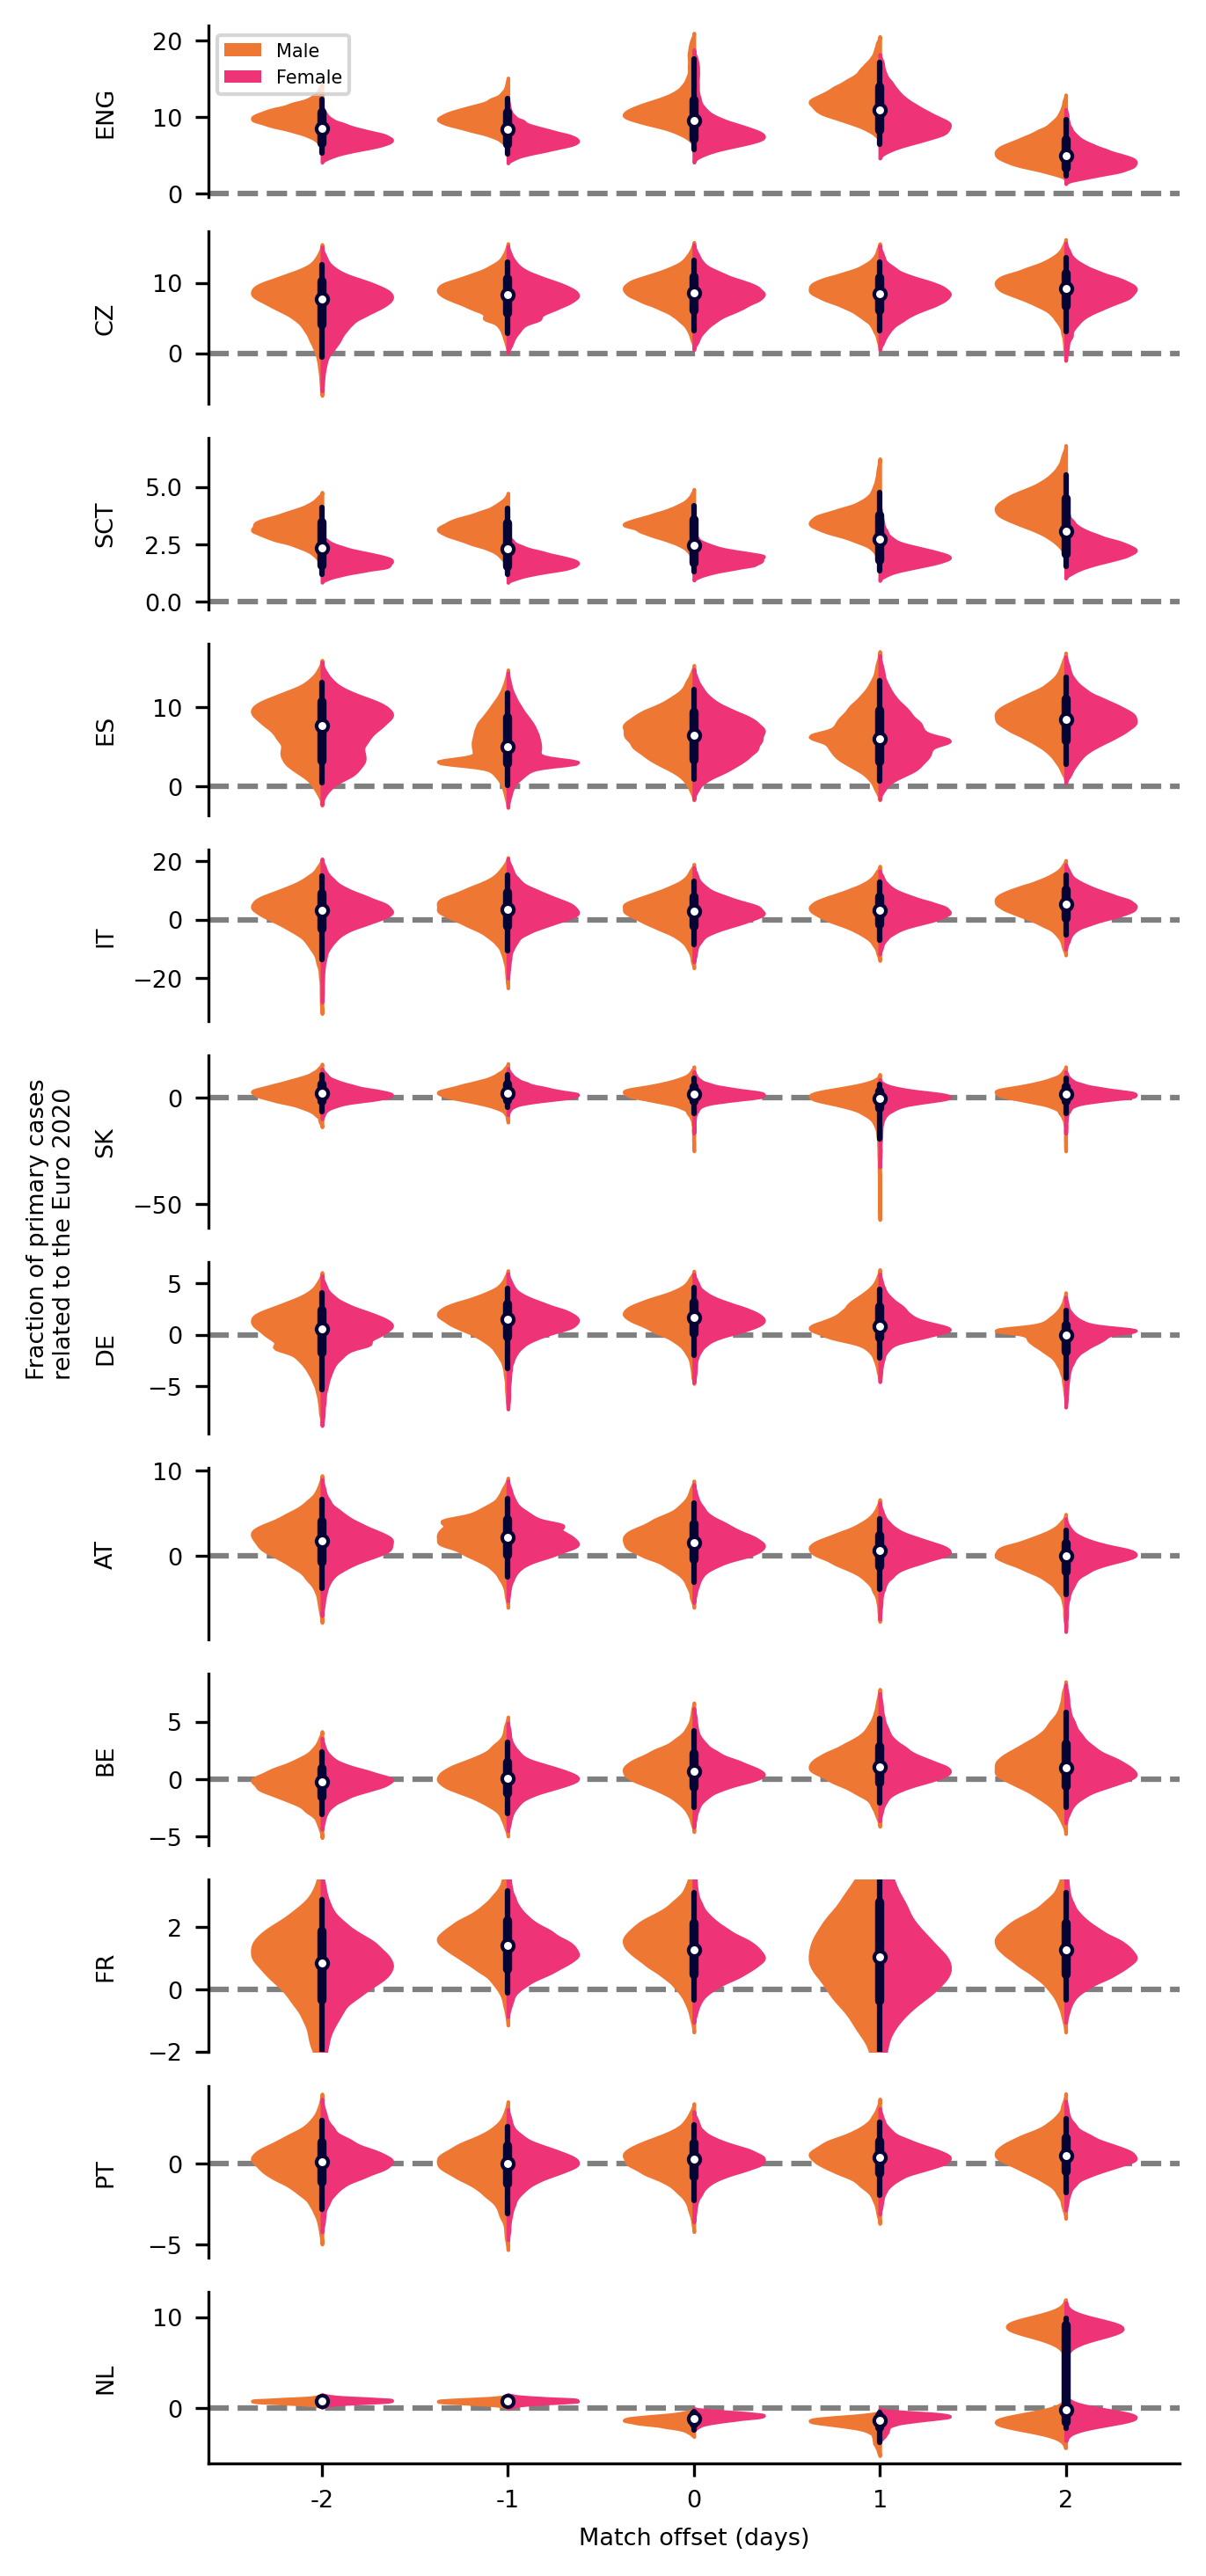

In [34]:
from covid19_soccer.plot.other import legend,hviolins


def whisker_plot(ax,x,y_median,y_lower_95,y_upper_95,y_lower_68,y_upper_68):
    lines = ax.vlines(
        x=x,
        ymin=y_lower_95,
        ymax=y_upper_95,
        lw=1.5,
        zorder=9,
        color="#060434",
        capstyle='round'
    )
    lines = ax.vlines(
        x=x,
        ymin=y_lower_68,
        ymax=y_upper_68,
        lw=2.5,
        zorder=9,
        color="#060434",
        capstyle='round'
    )
    lines.set_capstyle("round")
    ax.scatter(
        x=x,
        y=y_median,
        marker="o",
        s=10,
        zorder=10,
        c="white",
        edgecolor="#060434",
    )
    ax.spines["left"].set_visible(True)



plt.close("all")
fig,axes = plt.subplots(len(countries),1,figsize=(4.75,len(countries)*1))

for i, country in enumerate(countries):
    
    # Violins & whisker
    if country == "France":
        ci = [np.percentile(pf,q = (2.5,50,97.5,50-34,50+34)) for pf in [primary_frac[i][0].T,primary_frac[i][1].T,primary_frac[i][2].T,primary_frac[i-1][3].T,primary_frac[i][3].T]]
        ci = np.array(ci).T
        hviolins(
            axes[i],
            [primary_frac[i][0].T,primary_frac[i][1].T,primary_frac[i][2].T,primary_frac[i-1][3].T,primary_frac[i][3].T],
            offsets,
        )
        axes[i].set_ylim(-2,3.5)
    else:
        
        ci = [np.percentile(pf,q = (2.5,50,97.5,50-34,50+34)) for pf in primary_frac[i]]
        ci = np.array(ci).T
        
        hviolins(
            axes[i],
            [array.T for array in primary_frac[i]],
            offsets,
        )
    whisker_plot(
        axes[i],
        [0,1,2,3,4],
        ci[1,:],ci[0,:],ci[2,:],ci[3,:],ci[4,:],
    )


        
    # Markup
    if i == 0:
        axes[i].set_ylim(-0.5)
    axes[i].set_ylabel(dls[country][0].countries_iso2[0].replace("GB-",""))
    axes[i].set_xticklabels([])
    axes[i].get_legend().remove()
    axes[i].set_xlabel(None)
    axes[i].axhline(0,ls="--",color="tab:gray",zorder=-5)
    
    axes[i].spines["bottom"].set_visible(False)
    if i == len(countries)-1:
        axes[i].set_xticklabels(offsets)
        axes[i].spines["bottom"].set_visible(True)
        axes[i].set_xlabel("Match offset (days)")
    else:
        axes[i].xaxis.set_ticks_position('none')
    
    
legend(
    ax=axes[0],
    prior=False,
    posterior=False,
    model=False,
    data=False,
    sex=True,
    disable_axis=False,
    championship_range=False,
    loc="upper left",
)
fig.align_ylabels()
fig.supylabel("Fraction of primary cases\nrelated to the Euro 2020",x=-0.02)

fig.savefig(f"../figures/SI/delay_offset_overview.pdf", **save_kwargs)
fig.savefig(f"../figures/SI/delay_offset_overview.png", **save_kwargs)
plt.show()


## Offsets against delay

A:
--
- x : offset $[-2,2]$
- y : Delay

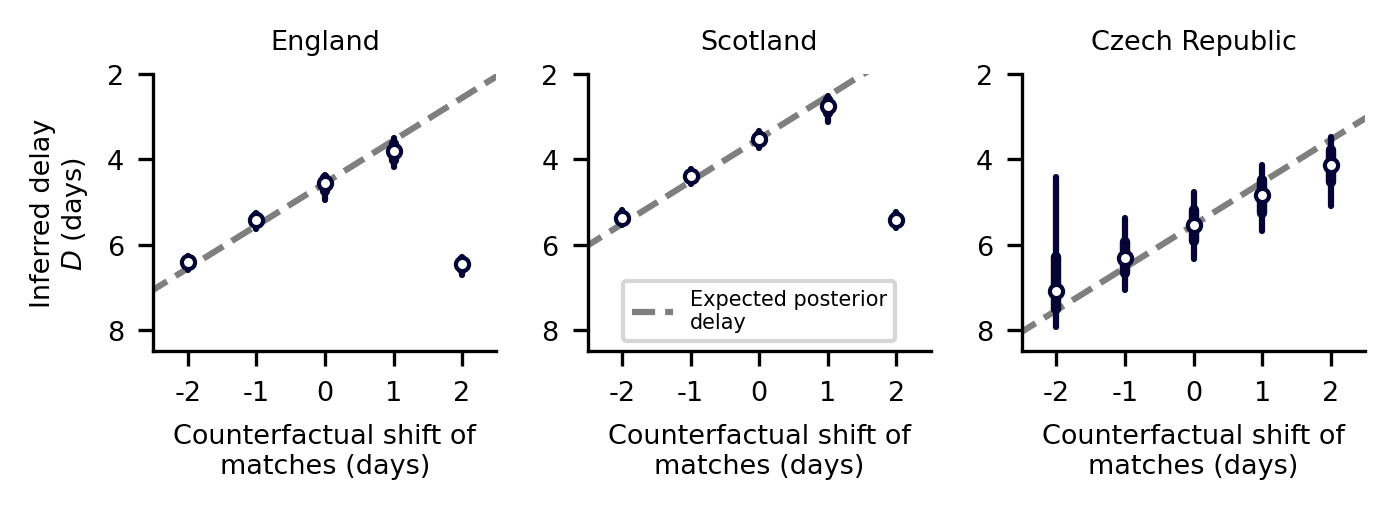

In [35]:
from covid19_soccer.plot.other import MulticolorPatch, MulticolorPatchHandler, Line2D, Rectangle, HandlerRect, rcParams
def whisker_plot(ax, x, y_median, y_lower_95, y_upper_95, y_lower_68, y_upper_68):
    lines = ax.vlines(
        x=x,
        ymin=y_lower_95,
        ymax=y_upper_95,
        lw=1.5,
        zorder=9,
        color="#060434",
        capstyle='round'
    )
    lines = ax.vlines(
        x=x,
        ymin=y_lower_68,
        ymax=y_upper_68,
        lw=2.5,
        zorder=9,
        color="#060434",
        capstyle='round'
    )
    lines.set_capstyle("round")
    ax.scatter(
        x=x,
        y=y_median,
        marker="o",
        s=10,
        zorder=10,
        c="white",
        edgecolor="#060434",
    )



def offset_delay_plot(ax,traces,models,dls):
    delays = []
    cis = []
    
    # compute values
    for tr in traces:
        delay = get_from_trace("delay",tr)
        delays.append(delay)
        
        ci = np.percentile(delay, q=(50, 2.5, 97.5, 16, 84))
        cis.append(ci)
    cis = np.array(cis)
    
    
    """Plots
    """
    
    # Whiskers 
    for i,ci in enumerate(cis):
        whisker_plot(ax,i,*ci)
    
    # Line
    intercept = cis[2][0]
    slope = -1
    
    x = np.array([-1,6])
    ax.plot(x,(x-2)*slope+intercept,ls="--",color="tab:gray")
    

def plot_legend(ax,loc="upper left"):
    """ Plot the legend onto an axis
    Parameters
    ----------
    ax: mpl axis
    loc: strin
        Location of the legend
    """
    # Legend
    handles = []
    labels = []
    handles.append(Line2D(
                [0],
                [0],
                color="tab:gray",
                ls="--",
                lw=1.5,
                marker=None,
                ms=3.5
            ))
    labels.append("Expected posterior\ndelay") 

    ax.legend(
        handles,
        labels,
        handler_map={MulticolorPatch: MulticolorPatchHandler(), Rectangle: HandlerRect(),},
        loc=loc,
    )
    return ax
    
fig, axes = plt.subplots(1,3,figsize=(4.75,1.8))


for i, c in enumerate(["England","Scotland","Czechia"]):
    ax = axes[i]
    offset_delay_plot(axes[i],traces[c],models[c],dls[c])

    ax.set_xticks([0,1,2,3,4])
    ax.set_xticklabels([-2,-1,0,1,2])
    ax.set_xlim([-0.5,4.5])
    if c == "Czechia":
        ax.set_title("Czech Republic")
    else:
        ax.set_title(c)
    ax.set_ylim(8.5,2)
    
    ax.set_xlabel("Counterfactual shift of\nmatches (days)")
    if i == 0:
        ax.set_ylabel("Inferred delay\n$D$ (days)")
    if i == 1:
        plot_legend(ax,"lower center")
        

fig.tight_layout()
fig.savefig(f"../figures/SI/delay_offset_eng_sct_cz.pdf", **save_kwargs)
fig.savefig(f"../figures/SI/delay_offset_eng_sct_cz.png", **save_kwargs)
plt.show()